In [1]:
# Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from keras.optimizers import Adam
from keras.regularizers import l2
from keras.models import load_model, Sequential
from keras.callbacks import EarlyStopping
from keras.metrics import RootMeanSquaredError
from keras.layers import InputLayer, Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

2025-04-13 15:51:31.170638: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-13 15:51:31.605923: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-13 15:51:31.908627: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744570292.180922   74026 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744570292.254649   74026 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [96]:
# Função para salvar todos os dados em um novo arquivo csv
def load_data():
  # Lista para armazenar os DataFrames individuais
  dfs = []

  # Carregar os dados
  for year in range(2007, 2025):
    file_path = f'./data/INMET_MG_PAMPULHA_{year}.CSV'
    df = pd.read_csv(file_path, sep=';', encoding='latin1')

    # Adicionar o DataFrame lido à lista
    dfs.append(df)

  # Concatenar todos os DataFrames em um único DataFrame
  data = pd.concat(dfs, ignore_index=True)

  # Renomear colunas
  data.columns = ['Data', 'Hora', 'Precipitação', 'Pressão atmosférica', 'Pressão Atmosférica MAX Hora Ant.',
                  'Pressão Atmosférica MIN Hora Ant.', 'Radiação solar', 'Temperatura ar', 'Temperatura orvalho', 
                  'Temperatura MAX Hora Ant.', 'Temperatura MIN Hora Ant.', 'Temperatura Orvalho MAX Hora Ant.', 
                  'Temperatura Orvalho MIN Hora Ant.', 'Umidade MAX Hora Ant.', 'Umidade MIN Hora Ant.',
                  'Umidade', 'Direção vento', 'Rajada vento', 'Velocidade vento']

  # Remover "UTC" da coluna de tempo
  data['Hora'] = data['Hora'].str.replace(' UTC', '')

  # Converter a hora do formato "HHMM" para "HH:MM"
  data['Hora'] = data['Hora'].apply(lambda x: f"{x[:2]}")

  # Converter data e hora para datetime
  data['datetime'] = pd.to_datetime(data['Data'] + ' ' + data['Hora'], format='%d/%m/%Y %H')
  
  # Conversão para Unix Timestamp
  #data['unix_timestamp'] = data['datetime'].apply(lambda dt: dt.timestamp())

  # Adiciona variáveis temporais úteis
  data['hora'] = data['datetime'].dt.hour
  data['mes'] = data['datetime'].dt.month
  data['dia_semana'] = data['datetime'].dt.dayofweek
  data['hora_sin'] = np.sin(2 * np.pi * data['hora'] / 24)
  data['hora_cos'] = np.cos(2 * np.pi * data['hora'] / 24)

  # Definir 'datetime' como índice e remover as colunas originais de data e hora
  data = data.set_index('datetime')
  data = data.drop(columns=['Data', 'Hora'])

  # Preencher valores ausentes
  data = data.replace(-9999, np.nan)
  data = data.ffill().bfill()

  # Remover linhas com NaN e o índice
  data = data.dropna()

  # Salva os dados relevantes para o treinamento em um novo arquivo csv
  data.to_csv('all_data.csv', sep=';', encoding='latin1')

In [97]:
# Executa a função e salva tudo em um arquivo csv
load_data()

In [45]:
# Carrega os dados
data = pd.read_csv('all_data.csv', sep=';', encoding='latin1')
data = data.set_index('datetime')

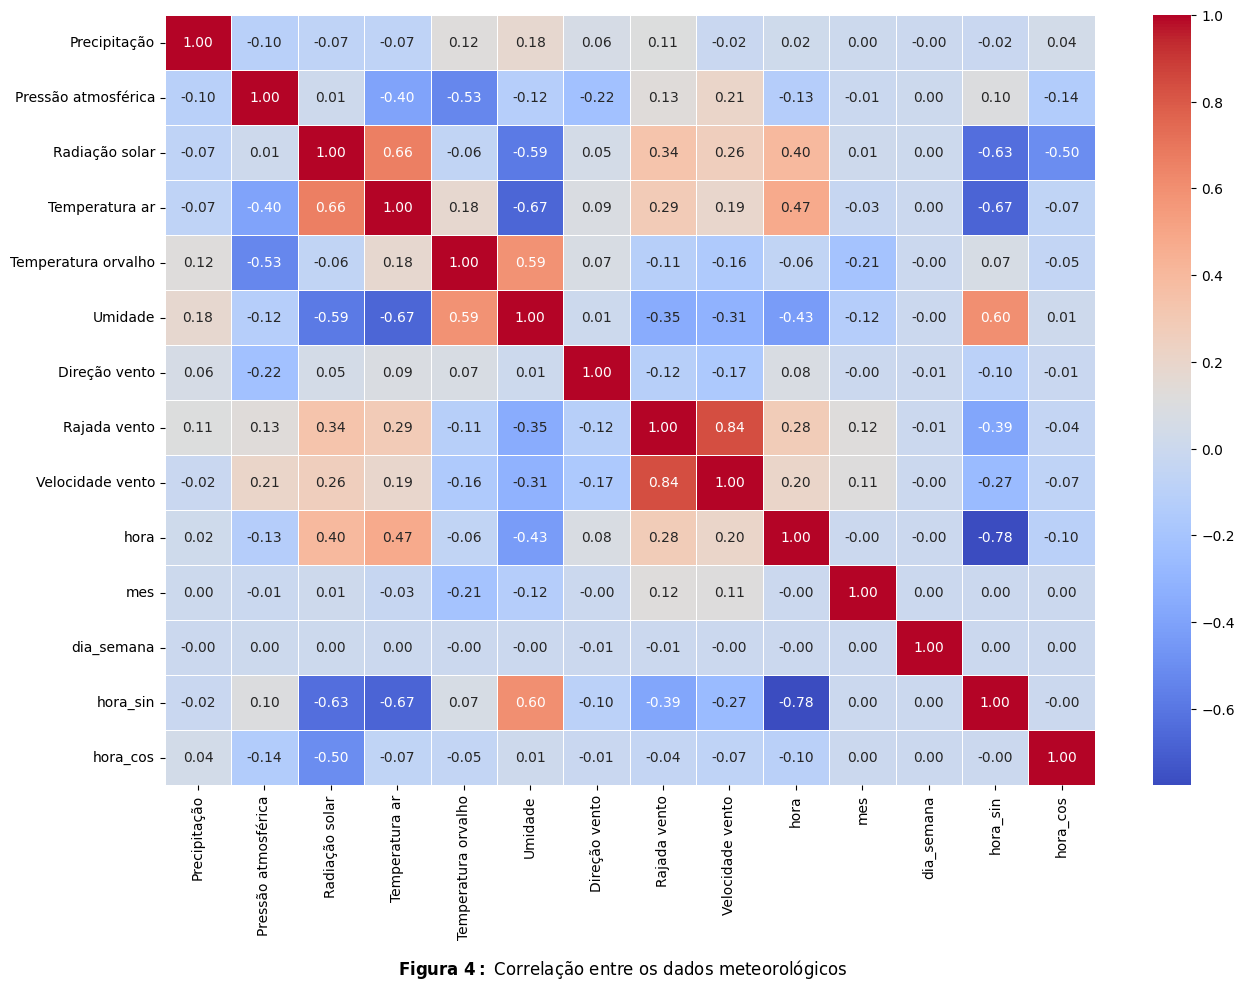

In [46]:
# Plota matriz de correlação
del_data = ['Pressão Atmosférica MAX Hora Ant.', 'Pressão Atmosférica MIN Hora Ant.', 'Temperatura MAX Hora Ant.', 'Temperatura MIN Hora Ant.', 
            'Temperatura Orvalho MAX Hora Ant.', 'Temperatura Orvalho MIN Hora Ant.', 'Umidade MAX Hora Ant.', 'Umidade MIN Hora Ant.',]

data = data.drop(columns=del_data, axis=1)
corr_matrix = data.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.gcf().text(0.43, -0.08, r'$\bf{Figura\ 4:}$ Correlação entre os dados meteorológicos', ha='center', fontsize=12)
plt.show()

In [13]:
# Prepara os dados para o treinamento
X = data.drop(columns='Temperatura ar').values
y = data['Temperatura ar'].values

# Dividir os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normaliza os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Adiciona dimensão extra para Conv1D (canal único)
X_train = X_train[..., np.newaxis]  # ou: X_train = X_train.reshape(-1, X_train.shape[1], 1)
X_test = X_test[..., np.newaxis]

# Verificar o shape dos dados divididos
print("Shape de X_train:", X_train.shape)
print("Shape de X_test:", X_test.shape)
print("Shape de y_train:", y_train.shape)
print("Shape de y_test:", y_test.shape)

Shape de X_train: (122131, 13, 1)
Shape de X_test: (30533, 13, 1)
Shape de y_train: (122131,)
Shape de y_test: (30533,)


In [19]:
# Rede Neural
model = Sequential([
  InputLayer( shape = (X_train.shape[1], X_train.shape[2]) ),
  Conv1D(filters=16, kernel_size=13, activation='tanh'),
  Flatten(),
  Dense(8, activation='tanh'),
  Dense(1)
])

model.compile(optimizer= Adam(learning_rate=1e-3) , loss='mae', metrics=[RootMeanSquaredError()])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, start_from_epoch=100)

history = model.fit(X_train, y_train, epochs=500, batch_size=128, validation_split=0.2, callbacks=[early_stopping], verbose=0)

# Salva o modelo treinado e historico (MAE e RMSE)
model.save('model_history/best_model.keras')

with open("model_history/history_best_model.pkl", "wb") as file:
  pickle.dump(history.history, file)

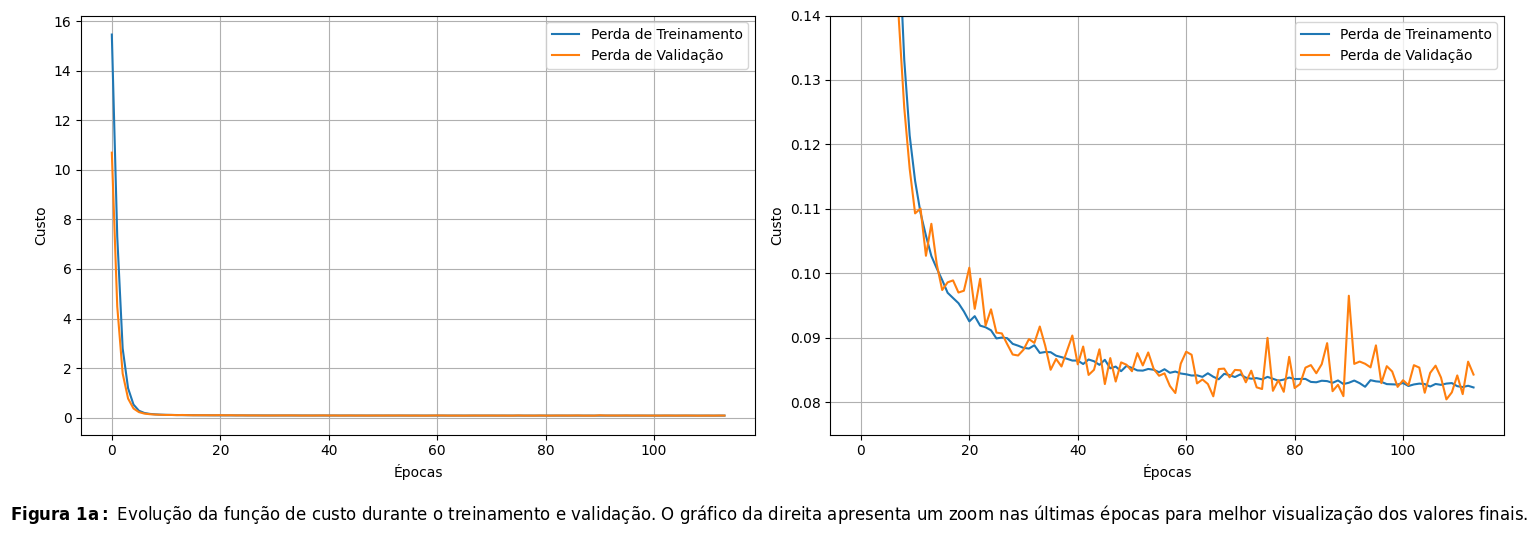

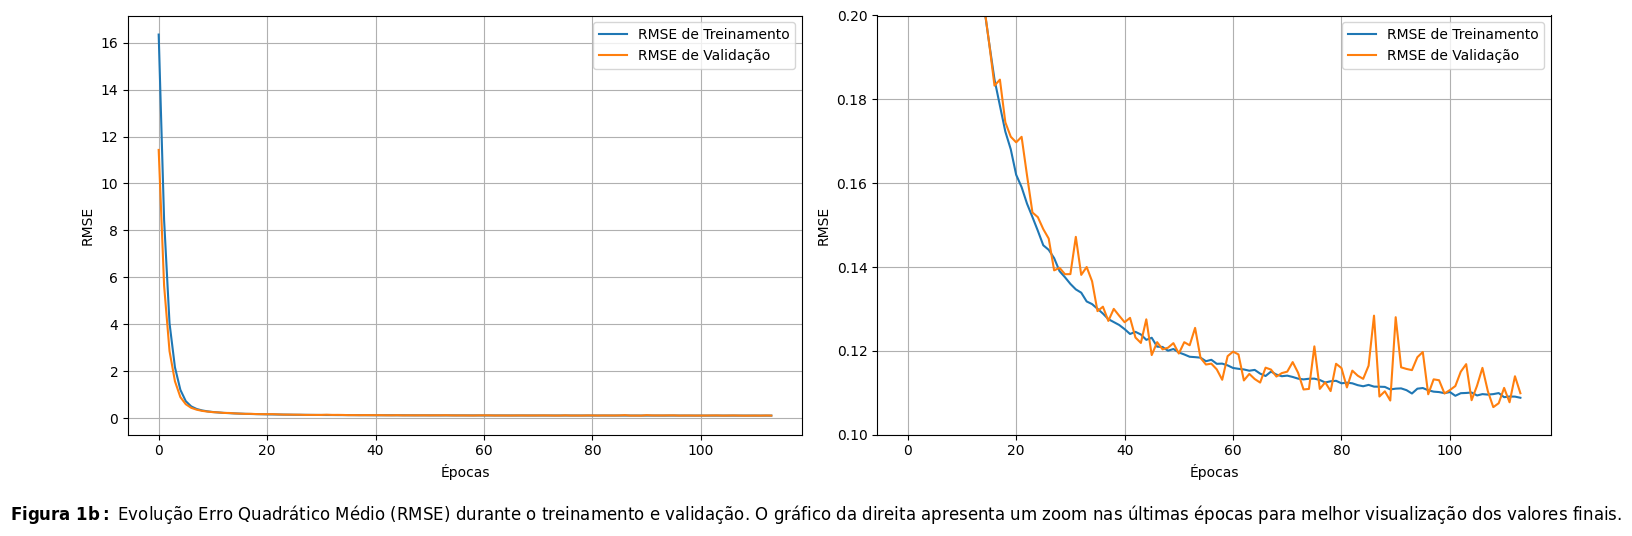

In [27]:
# Plotar a perda
fig_loss, axs_loss = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plotar a perda
axs_loss[0].plot(history.history['loss'], label='Perda de Treinamento')
axs_loss[0].plot(history.history['val_loss'], label='Perda de Validação')
axs_loss[0].set_xlabel('Épocas')
axs_loss[0].set_ylabel('Custo')
axs_loss[0].legend()
axs_loss[0].grid(True)

# Plotar a perda - zoom
axs_loss[1].plot(history.history['loss'], label='Perda de Treinamento')
axs_loss[1].plot(history.history['val_loss'], label='Perda de Validação')
axs_loss[1].set_ylim([0.075, 0.14]) #Melhora a visualização do gráfico
axs_loss[1].set_xlabel('Épocas')
axs_loss[1].set_ylabel('Custo')
axs_loss[1].legend()
axs_loss[1].grid(True)

fig_loss.text(0.5, -0.05, r'$\bf{Figura\ 1a:}$ Evolução da função de custo durante o treinamento e validação. O gráfico da direita apresenta um zoom nas últimas épocas para melhor visualização dos valores finais.', ha='center', fontsize=12)
fig_loss.tight_layout()

# ---------------------------------------------------------------------------------------------
# Plotar a RMSE
fig_metrics, axs_metrics = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plotar RMSE
axs_metrics[0].plot(history.history['root_mean_squared_error'], label='RMSE de Treinamento')
axs_metrics[0].plot(history.history['val_root_mean_squared_error'], label='RMSE de Validação')
axs_metrics[0].set_xlabel('Épocas')
axs_metrics[0].set_ylabel('RMSE')
axs_metrics[0].legend()
axs_metrics[0].grid(True)

# Plotar RMSE - zoom
axs_metrics[1].plot(history.history['root_mean_squared_error'], label='RMSE de Treinamento')
axs_metrics[1].plot(history.history['val_root_mean_squared_error'], label='RMSE de Validação')
axs_metrics[1].set_ylim([0.1, 0.2]) #Melhora a visualização do gráfico
axs_metrics[1].set_xlabel('Épocas')
axs_metrics[1].set_ylabel('RMSE')
axs_metrics[1].legend()
axs_metrics[1].grid(True)

fig_metrics.text(0.5, -0.05, r'$\bf{Figura\ 1b:}$ Evolução Erro Quadrático Médio (RMSE) durante o treinamento e validação. O gráfico da direita apresenta um zoom nas últimas épocas para melhor visualização dos valores finais.', ha='center', fontsize=12)
fig_metrics.tight_layout()


plt.show()

In [33]:
# Avaliar o modelo
y_pred = model.predict(X_test, verbose=0)
# Dados do INMET estão com 1 casa decimal por isso o arredondamento
y_pred = np.round(y_pred, 1)

# Métricas com sklearn
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

MAE: 0.07670406513590786
RMSE: 0.11206637087540505
R²: 0.9992251471840786


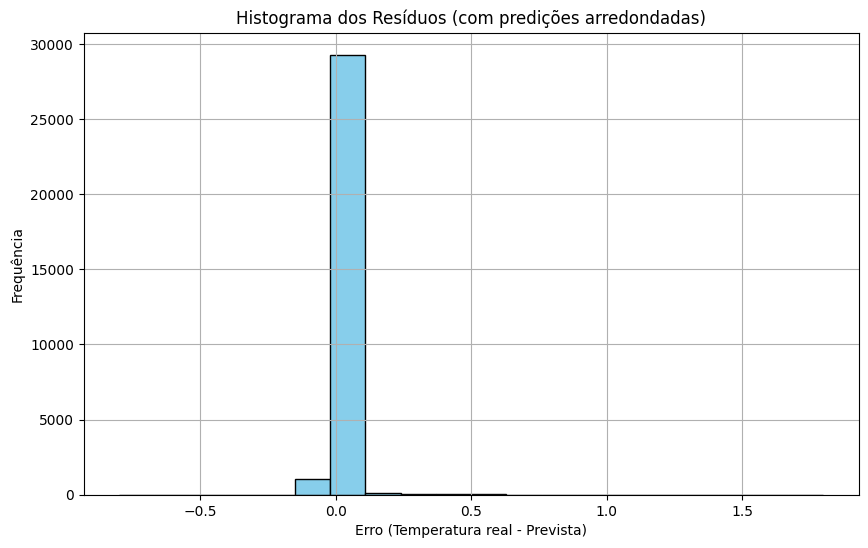

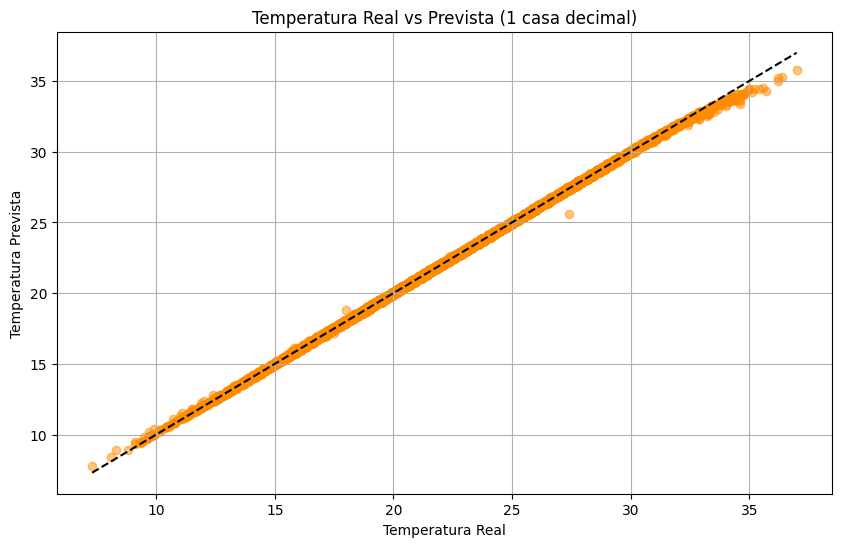

In [32]:
# Feito pelo chatgpt, conferir o significado
import numpy as np
import matplotlib.pyplot as plt

# 1. Arredonda predições para 1 casa decimal
y_pred_1casa = np.round(y_pred, 1)

# 2. Calcula resíduos (diferença entre real e previsto)
residuos = y_test - y_pred_1casa.flatten()

# 3. Histograma dos resíduos
plt.figure(figsize=(10,6))
plt.hist(residuos, bins=20, color='skyblue', edgecolor='black')
plt.title('Histograma dos Resíduos (com predições arredondadas)')
plt.xlabel('Erro (Temperatura real - Prevista)')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

# 4. Gráfico de dispersão real x previsto
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_1casa, alpha=0.5, color='darkorange')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--')  # Linha de igualdade
plt.title('Temperatura Real vs Prevista (1 casa decimal)')
plt.xlabel('Temperatura Real')
plt.ylabel('Temperatura Prevista')
plt.grid(True)
plt.show()


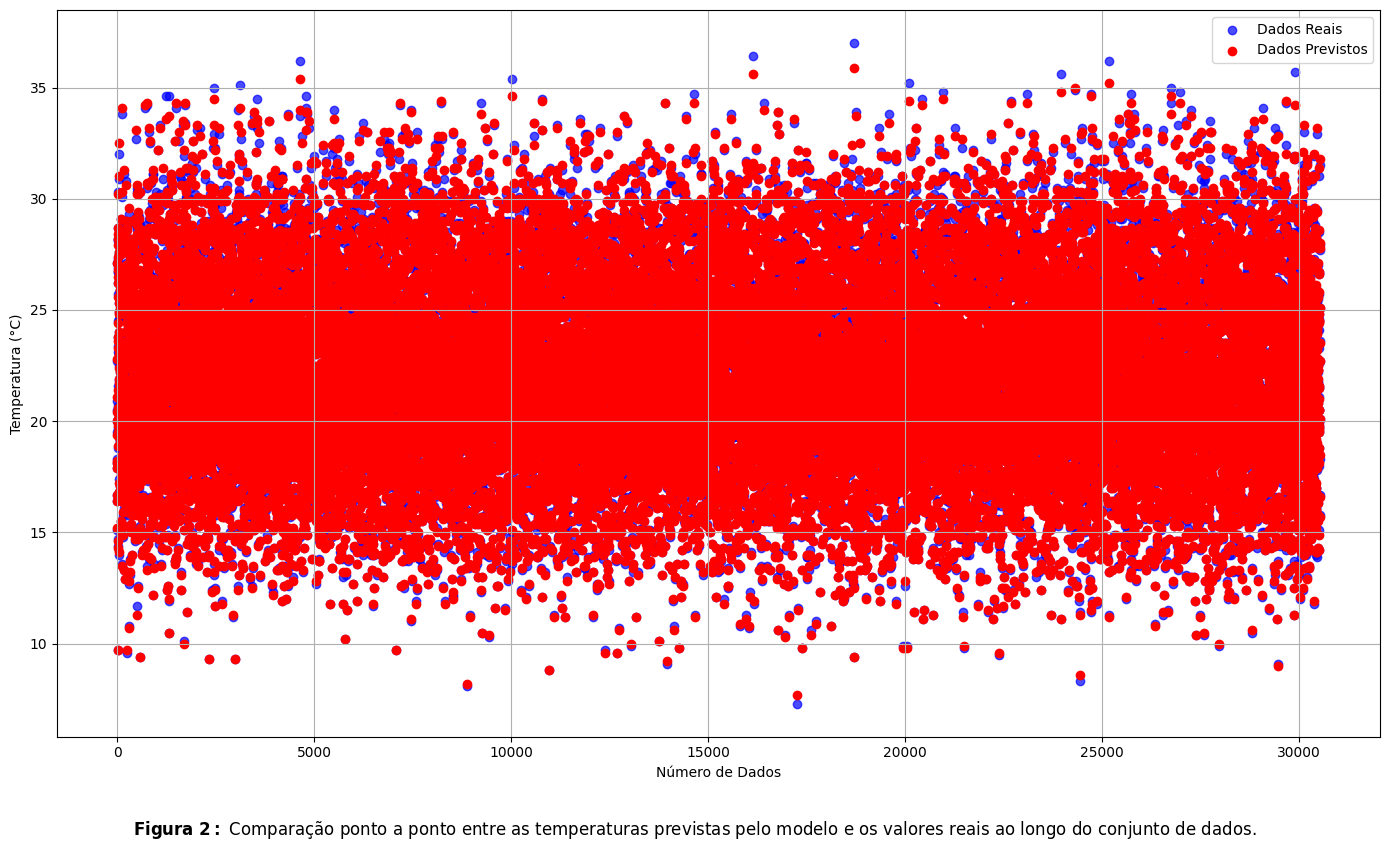

In [36]:
# Plota as temperaturas reais e previstas 
index = np.arange(len(y_pred))

# Plotar os dados reais e previstos no mesmo gráfico
plt.figure(figsize=(14, 8))
plt.scatter(index, y_test, color='blue', label='Dados Reais', alpha=0.7)
plt.scatter(index, y_pred, color='red', label='Dados Previstos')
plt.xlabel('Número de Dados')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True)
plt.gcf().text(0.5, -0.05, r'$\bf{Figura\ 2:}$ Comparação ponto a ponto entre as temperaturas previstas pelo modelo e os valores reais ao longo do conjunto de dados.', ha='center', fontsize=12)
plt.tight_layout()
plt.show()

Acurácia (com 1 casa decimal): 7.60%
Acurácia (com 0 casa decimal): 92.37%


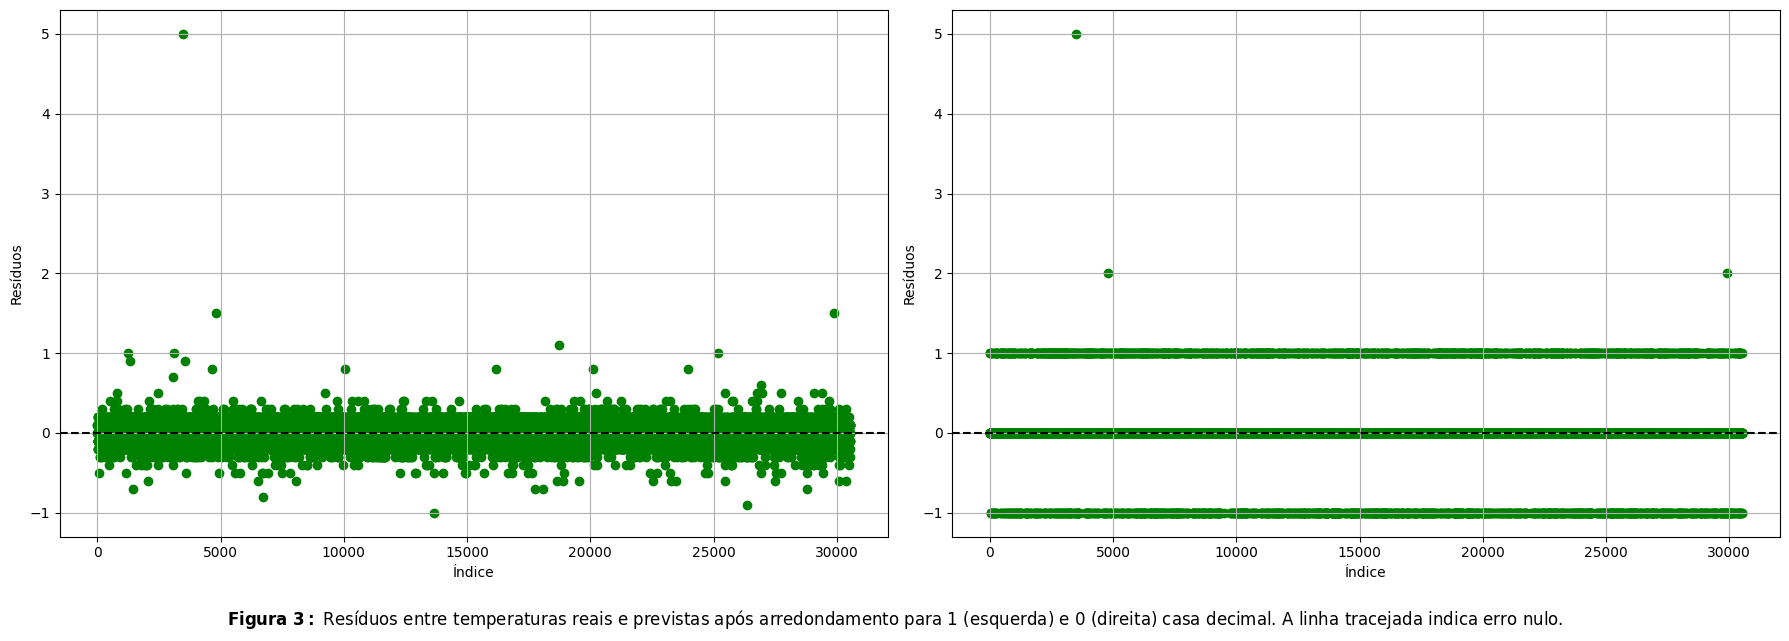

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))  # 2 linhas (precisão), 2 colunas (acertos/erros)

for idx, n in enumerate([1, 0]):  # 1 decimal e 0 decimal

  y_pred_right = []
  new_y_pred = []

  for i in range( len(y_pred) ):
    if np.round( y_pred[i][0], n ) == np.round( y_test[i], n ):
      y_pred_right.append( np.round(y_pred[i][0], n) )
    
    new_y_pred.append( np.round(y_pred[i][0], n) )

  acc = len(y_pred_right) / len(y_pred) * 100
  print(f'Acurácia (com {n} casa decimal): {acc:.2f}%')

  residue = np.round(np.array(y_test), n) - np.array(new_y_pred)
  index = np.arange(len(residue))

  # Gráfico dos acertos
  axes[idx].scatter(index, residue, color='green')
  axes[idx].axhline(y=0, color='black', linestyle='dashed')
  axes[idx].set_xlabel('Índice')
  axes[idx].set_ylabel('Resíduos')
  axes[idx].grid(True)

# Ajusta layout e legendas abaixo dos gráficos
plt.figtext(0.5, -0.05, r'$\bf{Figura\ 3:}$ Resíduos entre temperaturas reais e previstas após arredondamento para 1 (esquerda) e 0 (direita) casa decimal. A linha tracejada indica erro nulo.', ha='center', fontsize=12)
plt.tight_layout()
plt.show()


In [47]:

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 1, 16)          │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,109 (4.34 KB)

 Trainable params: 369 (1.44 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 740 (2.89 KB)